# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

In [2]:
!pip install pandas sklearn scikit-learn


## Import Libraries

In [3]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [4]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1


In [5]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'mps'
#device = 'cuda'

## Load Data

In [8]:
os.makedirs('data', exist_ok=True)

In [9]:
with zipfile.ZipFile('tasks.zip') as tasks_zip:
    tasks_zip.extractall('data')

In [10]:
train_list = glob.glob('data/tasks/**/train/*.png', recursive=True)
test_list = glob.glob('data/tasks/**/test/*.png', recursive=True)

In [11]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 30123
Test Data: 3345


In [12]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

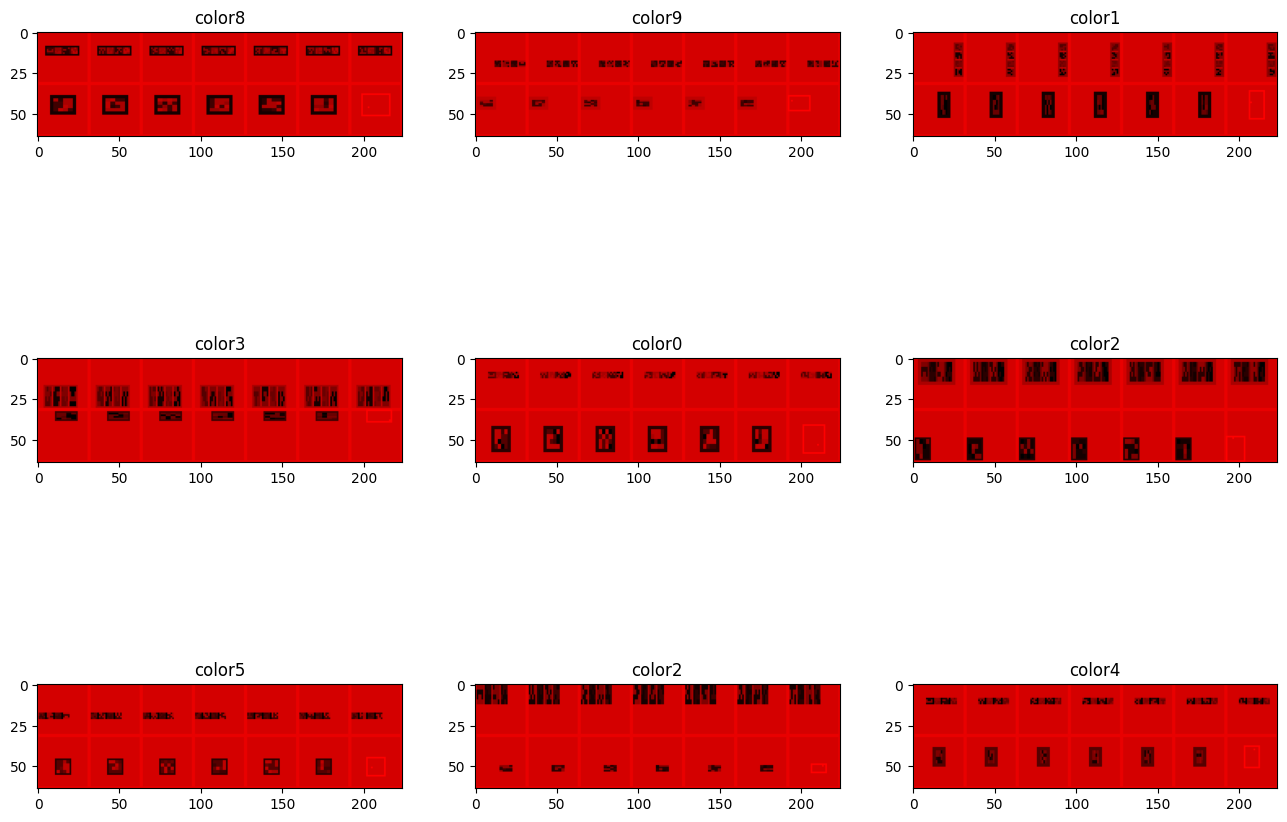

In [13]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [14]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [15]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 24098
Validation Data: 6025
Test Data: 3345


## Image Augmentation

In [16]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [17]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        raw_label = img_path.split("/")[-1].split(".")[0]
        label = 0
        if raw_label == "color0":
            label = 0
        if raw_label == "color1":
            label = 1
        if raw_label == "color2":
            label = 2
        if raw_label == "color3":
            label = 3
        if raw_label == "color4":
            label = 4
        if raw_label == "color5":
            label = 5
        if raw_label == "color6":
            label = 6
        if raw_label == "color7":
            label = 7
        if raw_label == "color8":
            label = 8
        if raw_label == "color9":
            label = 9
            
        return img_transformed, label


In [18]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))

24098 377


In [21]:
print(len(valid_data), len(valid_loader))

6025 95


## Efficient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [23]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [25]:
!pip install ipywidgets

In [26]:
from tqdm import tqdm

In [42]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.08it/s]


Epoch : 1 - loss : 1.9098 - acc: 0.3059 - val_loss : 1.8991 - val_acc: 0.3033



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.04it/s]


Epoch : 2 - loss : 1.8931 - acc: 0.3168 - val_loss : 1.9105 - val_acc: 0.3036



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  5.00it/s]


Epoch : 3 - loss : 1.8967 - acc: 0.3120 - val_loss : 1.8958 - val_acc: 0.3077



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  4.99it/s]


Epoch : 4 - loss : 1.8893 - acc: 0.3122 - val_loss : 1.9294 - val_acc: 0.3093



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.07it/s]


Epoch : 5 - loss : 1.8755 - acc: 0.3213 - val_loss : 1.9048 - val_acc: 0.3048



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.05it/s]


Epoch : 6 - loss : 1.8805 - acc: 0.3165 - val_loss : 1.9010 - val_acc: 0.3119



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:16<00:00,  4.93it/s]


Epoch : 7 - loss : 1.8754 - acc: 0.3217 - val_loss : 1.8994 - val_acc: 0.3087



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:16<00:00,  4.91it/s]


Epoch : 8 - loss : 1.8738 - acc: 0.3196 - val_loss : 1.9241 - val_acc: 0.3070



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  5.01it/s]


Epoch : 9 - loss : 1.8609 - acc: 0.3237 - val_loss : 1.8754 - val_acc: 0.3194



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.05it/s]


Epoch : 10 - loss : 1.8640 - acc: 0.3196 - val_loss : 1.8647 - val_acc: 0.3209



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.05it/s]


Epoch : 11 - loss : 1.8574 - acc: 0.3219 - val_loss : 1.8754 - val_acc: 0.3058



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.08it/s]


Epoch : 12 - loss : 1.8584 - acc: 0.3236 - val_loss : 1.8671 - val_acc: 0.3336



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:13<00:00,  5.13it/s]


Epoch : 13 - loss : 1.8489 - acc: 0.3311 - val_loss : 1.8624 - val_acc: 0.3317



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:13<00:00,  5.14it/s]


Epoch : 14 - loss : 1.8435 - acc: 0.3296 - val_loss : 1.8542 - val_acc: 0.3134



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:12<00:00,  5.19it/s]


Epoch : 15 - loss : 1.8354 - acc: 0.3321 - val_loss : 1.8495 - val_acc: 0.3009



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  4.98it/s]


Epoch : 16 - loss : 1.8292 - acc: 0.3316 - val_loss : 1.8631 - val_acc: 0.3140



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:16<00:00,  4.94it/s]


Epoch : 17 - loss : 1.8345 - acc: 0.3294 - val_loss : 1.8488 - val_acc: 0.3270



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  4.97it/s]


Epoch : 18 - loss : 1.8256 - acc: 0.3361 - val_loss : 1.8828 - val_acc: 0.3062



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:15<00:00,  5.00it/s]


Epoch : 19 - loss : 1.8225 - acc: 0.3382 - val_loss : 1.8663 - val_acc: 0.3246



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 377/377 [01:14<00:00,  5.08it/s]


Epoch : 20 - loss : 1.8189 - acc: 0.3367 - val_loss : 1.9101 - val_acc: 0.2798



In [38]:
# Print model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [37]:
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

In [43]:
state = {
    'epoch': epoch,
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, 'checkpoint.pt')

In [91]:
checkpoint = torch.load('checkpoint.pt')
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']

In [28]:
#optimizer
#model

In [44]:
import arc_json_model as ajm
from visualize import ajm_image_show
import export_task_to_image as etti
from pil_image_from_pixels import pil_image_from_pixels_with_red_palette
from simple_image import image_new, set_pixel, draw_rect, draw_box

ajm.Image.show = ajm_image_show

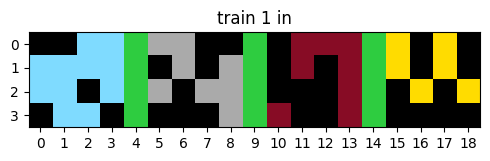

In [45]:
#filename = 'testdata/af902bf9.json'
#filename = 'testdata/cf98881b.json'
filename = 'testdata/281123b4.json'
task = ajm.Task.load(filename)
image = task.pairs[1].input
image.show()

output size:  4 4


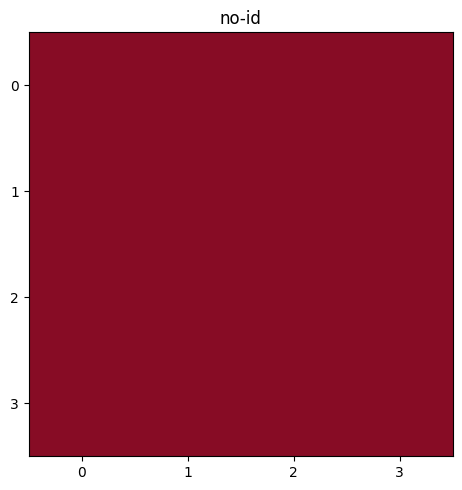

In [46]:
exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)
        tensor = test_transforms(pil_image)
        tensor = tensor[None, :]
        #if x == 2 and y == 2:
            #pil_image.show()
            #print(tensor.shape)

        data = tensor.to(device)
        output = model(data)
        #print(output)
        output_tensor = output.cpu().detach()
        #print(output_tensor)
        output_value = output_tensor.argmax(dim=1)
        #print(output_value)
        #result_pixels
        set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()

In [125]:
class SingleImageDataset(Dataset):
    def __init__(self, single_image: Image, transform=None):
        self.single_image = single_image
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        image = self.single_image.copy()
        if self.transform:
            image = self.transform(image)
        label = 42
        return image, label

output size:  4 4
x, y 0 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 0
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 1 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 2 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 3 1
tensor([[ 0.1438,  0.4753,  0.2801, -0.0504,  0.2638, -0.3030, -0.0329, -0.4715,
          0.4869,  0.6095]])
x, y 0 2
tensor([[ 0.1438,  0.

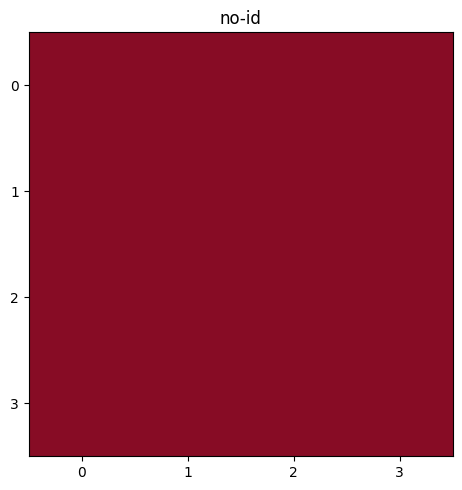

In [131]:

exporter = etti.ExportTaskToImage(task)
pair = task.pairs[0]
output_image_shape = pair.output.pixels.shape
width = output_image_shape[1]
height = output_image_shape[0]
print("output size: ", width, height)
predicted_pixels = image_new(width, height, 255)
for y in range(height):
    for x in range(width):
        print("x, y", x, y)
        pixels = exporter.image_with_mark(0, x, y)
        pil_image = pil_image_from_pixels_with_red_palette(pixels)
        
        my_data = SingleImageDataset(pil_image, transform=test_transforms)
        my_loader = DataLoader(dataset = my_data, batch_size=batch_size, shuffle=True)
        for data, label in my_loader:
            #for data, label in tqdm(my_loader):
            #print(data.shape)
            data = data.to(device)

            output = model(data)
            #print(output)
            output_tensor = output.cpu().detach()
            print(output_tensor)
            output_value = output_tensor.argmax(dim=1)
            #print(output_value)
            #result_pixels
            set_pixel(predicted_pixels, x, y, output_value)

predicted_image = ajm.Image(predicted_pixels, 'no-id')
predicted_image.show()